# <font color='#1a5276'> <b> <center> Batch Normalization </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Theoretical base](#2)
3. [Setup](#3)
4. [Helper Functions](#4)
5. [Data](#5)
6. [Model](#6)
7. [Training Function](#7)
8. [Experiments](#8) <br>
    8.1. [Experiments](#8.1) <br>
    8.2.[Experiments](#8.2) <br>
9. [Analysis](#9)
10. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

This notebook demonstrates how Batch Normalization can enhance the performance of deep learning models by stabilizing training, accelerating convergence, and acting as an implicit regularizer. We'll compare models with and without Batch Normalization to highlight its impact on training dynamics and generalization.

<a name="2"></a>
## <font color='blue'> <b> 2. Theoretical base </b> </font>

### <font color='#1f618d'> Key Points: Batch Normalization (BN) </font>

1. **Purpose of Batch Normalization**:
   - Addresses **vanishing/exploding gradients** and improves training stability.
   - Tackles the **Internal Covariate Shift** problem (where the input distribution of each layer changes during training).


2. **Technique Overview**:
   - Adds an operation **before the activation function** of each layer.
   - **Zero-centers** and **normalizes** the inputs.
   - **Scales** and **shifts** the result using two learnable parameters:
     - Scale (gamma)
     - Shift (beta)


3. **Learning Optimal Scale and Mean**:
   - Allows the model to learn the **optimal input scale and mean** for each layer.


4. **Mean and Standard Deviation Estimation**:
   - During <b> <font color='red'> training </font> </b>:
     - Computes the **mean (mu)** and **standard deviation (sigma)** over the current mini-batch.
     
   - During <b> <font color='green'> inference (test time) </font> </b>:
     - Uses the **whole training set’s mean and standard deviation** (typically computed during training using a moving average).


5. **Parameters for Batch-Normalized Layers**:
   - Four parameters per layer are learned or tracked:
     - Scale (gamma)
     - Offset (Shift) (beta)
     - Mean (mu)
     - Standard Deviation (sigma)




<a name="3"></a>
## <font color='blue'> <b> 3. Setup </b> </font>

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

In [4]:
torch.manual_seed(0)

<a name="4"></a>
## <font color='blue'> <b> 4. Helper Functions </b> </font>

In [33]:
# histogram of activations
def activations_histogram(model, model_bn, validation_dataset):
    # get activation for the first model
    out = model.activation(validation_dataset[0][0].reshape(-1,28*28))
    # histogram
    plt.hist(out[2],label='Model with no batch normalization' )
    # activation for the second model
    out_norm = model_bn.activation(validation_dataset[0][0].reshape(-1,28*28))
    # histogram
    plt.hist(out_norm[2],label='Model with normalization')
    # title and labels
    plt.title("Histogram of activations")
    plt.xlabel("Activation ")
    plt.legend()
    plt.show()
    
# plot training
def plot_comparison(loss_accuracy_model1, loss_accuracy_model2):
    """
    Plots training and validation loss/accuracy for two models to compare their performance.

    Parameters:
    - loss_accuracy_model1: Dictionary containing training/validation loss and accuracy for model 1.
    - loss_accuracy_model2: Dictionary containing training/validation loss and accuracy for model 2.
    """
    epochs = range(1, len(loss_accuracy_model1['training_loss']) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Plot training loss
    axes[0, 0].plot(epochs, loss_accuracy_model1['training_loss'], label='Without BN', color='blue')
    axes[0, 0].plot(epochs, loss_accuracy_model2['training_loss'], label='With BN', color='orange')
    axes[0, 0].set_title('Training Loss', fontweight='bold')
    axes[0, 0].set_xlabel('Iterations')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Plot training accuracy
    axes[0, 1].plot(loss_accuracy_model1['training_accuracy'], label='Without BN', color='blue')
    axes[0, 1].plot(loss_accuracy_model2['training_accuracy'], label='With BN', color='orange')
    axes[0, 1].set_title('Training Accuracy', fontweight='bold')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()

    # Plot validation loss
    axes[1, 0].plot(loss_accuracy_model1['validation_loss'], label='Without BN', color='blue')
    axes[1, 0].plot(loss_accuracy_model2['validation_loss'], label='With BN', color='orange')
    axes[1, 0].set_title('Validation Loss', fontweight='bold')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()

    # Plot validation accuracy
    axes[1, 1].plot(loss_accuracy_model1['validation_accuracy'], label='Without BN', color='blue')
    axes[1, 1].plot(loss_accuracy_model2['validation_accuracy'], label='With BN', color='orange')
    axes[1, 1].set_title('Validation Accuracy', fontweight='bold')
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

<a name="5"></a>
## <font color='blue'> <b> 5. Data </b> </font>

We will use the MNIST data.

In [6]:
# load the train dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

In [7]:
# load the train dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [8]:
# Create Data Loader for both train and validating
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

<a name="6"></a>
## <font color='blue'> <b> 6. Model </b> </font>

In [9]:
input_size = 28 * 28 # 28x28 greyscale images
hidden_dim = 100
output_dim = 10 # 10 different outputs

### Model architecture

In [10]:
# Define the Neural Network Model with optional Batch Normalization
class Net(nn.Module):
    """
    A neural network with optional Batch Normalization layers.
    
    Attributes:
        use_batch_norm (bool): Whether to apply Batch Normalization.
        linear1 (nn.Linear): The first fully connected layer.
        linear2 (nn.Linear): The second fully connected layer.
        linear3 (nn.Linear): The output layer.
        bn1 (nn.BatchNorm1d): Batch Normalization layer for the first hidden layer (optional).
        bn2 (nn.BatchNorm1d): Batch Normalization layer for the second hidden layer (optional).
    """
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size, use_batch_norm=True):
        """
        Initializes the network layers and optionally Batch Normalization layers.
        
        Args:
            in_size (int): Number of input features.
            n_hidden1 (int): Number of neurons in the first hidden layer.
            n_hidden2 (int): Number of neurons in the second hidden layer.
            out_size (int): Number of output features.
            use_batch_norm (bool): Whether to include Batch Normalization in the network.
        """
        super(Net, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.linear1 = nn.Linear(in_size, n_hidden1)  # First fully connected layer
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)  # Second fully connected layer
        self.linear3 = nn.Linear(n_hidden2, out_size)  # Output layer
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm1d(n_hidden1)  # Batch Normalization for first hidden layer
            self.bn2 = nn.BatchNorm1d(n_hidden2)  # Batch Normalization for second hidden layer
        
    # Forward pass
    def forward(self, x):
        """
        Defines the forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        if self.use_batch_norm:
            # Apply Batch Norm after the first and second layers
            x = self.bn1(torch.sigmoid(self.linear1(x)))
            x = self.bn2(torch.sigmoid(self.linear2(x)))
        else:
            # Skip Batch Norm and directly apply activation
            x = torch.sigmoid(self.linear1(x))
            x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)  # Output layer
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        """
        Returns intermediate activations and pre-activations for analysis.
        
        Args:
            x (torch.Tensor): Input tensor.
        
        Returns:
            list: List of intermediate pre-activations and activations as NumPy arrays.
        """
        out = []
        if self.use_batch_norm:
            # Apply Batch Norm for the first layer
            z1 = self.bn1(self.linear1(x))
            out.append(z1.detach().numpy().reshape(-1))  # Pre-activation after first layer
            a1 = torch.sigmoid(z1)
        else:
            # Skip Batch Norm for the first layer
            z1 = self.linear1(x)
            out.append(z1.detach().numpy().reshape(-1))  # Pre-activation after first layer
            a1 = torch.sigmoid(z1)
        
        out.append(a1.detach().numpy().reshape(-1))  # Activation after first layer
        
        if self.use_batch_norm:
            # Apply Batch Norm for the second layer
            z2 = self.bn2(self.linear2(a1))
        else:
            # Skip Batch Norm for the second layer
            z2 = self.linear2(a1)
        
        out.append(z2.detach().numpy().reshape(-1))  # Pre-activation after second layer
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))  # Activation after second layer
        
        return out


### Criterion

In [11]:
# cross-entropy loss
criterion = nn.CrossEntropyLoss()

<a name="7"></a>
## <font color='blue'> <b> 7. Training function</b> </font>

In [12]:
def train(model, criterion, train_loader, validation_loader, optimizer, input_size=input_size, epochs=100):
    """
    Train a given model on a dataset and validate it periodically.

    Parameters:
    - model: The neural network model to be trained.
    - criterion: The loss function used for optimization.
    - train_loader: DataLoader for the training dataset, providing batches of data.
    - validation_loader: DataLoader for the validation dataset.
    - optimizer: The optimizer used to update the model's weights.
    - input_size: input size of the image (28*28 for mnist)
    - epochs (int): Number of epochs (iterations over the entire dataset).

    Returns:
    - loss_accuracy (dict): A dictionary containing:
        - 'training_loss': A list of training loss values for each batch.
        - 'validation_loss': A list of validation loss values at the end of each epoch.
        - 'training_accuracy': A list of training accuracy values at the end of each epoch.
        - 'validation_accuracy': A list of validation accuracy values at the end of each epoch.
    """
    
    loss_accuracy = {
        'training_loss': [],
        'validation_loss': [],
        'training_accuracy': [],
        'validation_accuracy': []
    }

    for epoch in range(epochs):  # Loop over each epoch
        model.train()  # Set the model to training mode
        # Track training metrics
        correct_train = 0
        total_train = 0

        # i: index of the batch, x: image, y: label
        for i, (x, y) in enumerate(train_loader):  # Loop over training batches
            optimizer.zero_grad()  # Reset gradients for the optimizer
            z = model(x.view(-1, input_size))  # Flatten input and forward pass through the model
            loss = criterion(z, y)  # Compute the loss
            loss.backward()  # Backpropagate the gradients
            optimizer.step()  # Update model weights using the optimizer

            loss_accuracy['training_loss'].append(loss.data.item())  # Record the loss value

            # Calculate training accuracy
            _, label = torch.max(z, 1)  # Get predicted labels
            correct_train += (label == y).sum().item()  # Count correct predictions
            total_train += y.size(0)  # Total number of samples in the batch

        training_accuracy = 100 * (correct_train / total_train)  # Calculate training accuracy
        loss_accuracy['training_accuracy'].append(training_accuracy)  # Record training accuracy

        # Track validation metrics
        model.eval()  # Set the model to evaluation mode
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():  # Disable gradient computation during validation
            for x, y in validation_loader:  # Loop over validation batches
                yhat = model(x.view(-1, input_size))  # Flatten input and forward pass through the model
                loss = criterion(yhat, y)  # Compute validation loss
                val_loss += loss.item()  # Sum validation loss

                _, label = torch.max(yhat, 1)  # Get the predicted class label
                correct_val += (label == y).sum().item()  # Count correct predictions
                total_val += y.size(0)  # Total number of samples in the batch

        validation_accuracy = 100 * (correct_val / total_val)  # Calculate validation accuracy
        val_loss /= len(validation_loader)  # Average validation loss

        loss_accuracy['validation_accuracy'].append(validation_accuracy)  # Record validation accuracy
        loss_accuracy['validation_loss'].append(val_loss)  # Record validation loss

    return loss_accuracy  # Return the dictionary with all metrics


Note that we save the training_loss for every iteration and the rest of the metrics per epoch.

- training_loss will have the shape (num_batches * num_epochs), tracking the loss for every batch.

- training_accuracy, validation_loss, and validation_accuracy will each have the shape (num_epochs), tracking these metrics at the end of each epoch.

<a name="8"></a>
## <font color='blue'> <b> 8. Expermiments </b> </font>


<a name="8.1"></a>
### <font color='#2874a6'> <b> 8.1. Without batch normalization </b> </font>


In [13]:
model = Net(input_size, hidden_dim, hidden_dim, output_dim, use_batch_norm=False)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

In [15]:
len(training_results['training_loss']) # num_batches*num_epochs = (len(train_ds)/batch_size) / num_epochs
                                       # = (60000/2000)*5 = 150 in this example

150

In [16]:
len(training_results['training_accuracy']) # = num_epochs=5

5

<a name="8.2"></a>
### <font color='#2874a6'> <b> 8.2. With batch normalization </b> </font>

In [18]:
model_bn = Net(input_size, hidden_dim, hidden_dim, output_dim, use_batch_norm=True)
optimizer_bn = torch.optim.Adam(model_bn.parameters(), lr = 0.1)
training_results_bn = train(model_bn, criterion, train_loader, validation_loader, optimizer_bn, epochs=5)

<a name="9"></a>
## <font color='blue'> <b> 9. Analysis </b> </font>

Let's see the histogram of the activations.

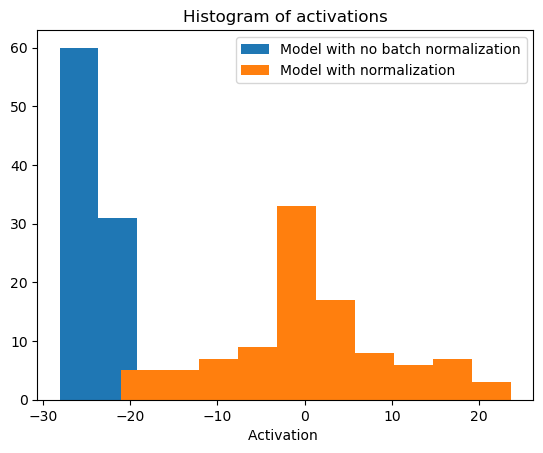

In [26]:
# set the models to evaluation mode
model.eval()
model_bn.eval()

# histogram
activations_histogram(model, model_bn, validation_dataset)

Let's plot the training:

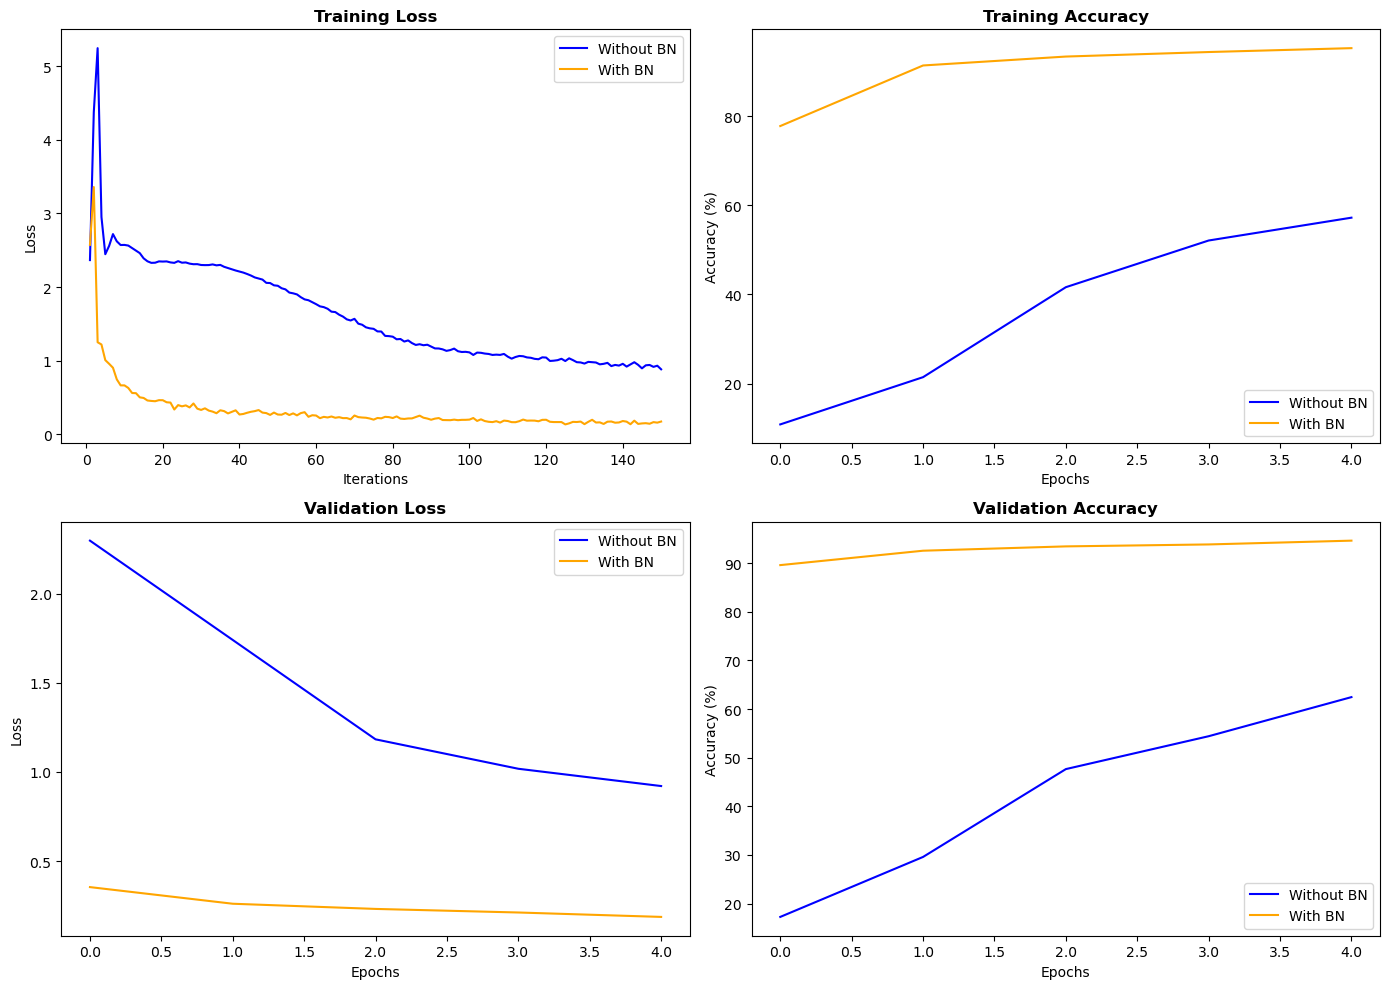

In [34]:
# Example usage after training both models
plot_comparison(training_results, training_results_bn)

We can see that by using batch normalization, we achieve better results and the training is faster.

<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)

[PyTorch documentation](https://pytorch.org/docs/stable/index.html)